# Exercise 2: Implicit Shape Model
**Task**: Develop a first prototype of your own ***Implicit Shape Model*** object detection system.

### Preparation
1. Take several images (at least 10) for an object that is of interest to you in front of a homogeneous background or in front of a blue screen.
2. Take as many images of a typical background of you object type.
3. Take as many images of an object in front of typical background.

### Software development
1. Code a jupyter notebook (you may take this as a starting point) that trains an implicit shape model for your object class. Take the lecture slides and Leibe, B., Leonardis, A., & Schiele, B. (2004, May). Combined object categorization and segmentation with an implicit shape model. In Workshop on statistical learning in computer vision, ECCV (Vol. 2, No. 5, p. 7) as a role model.
2. Code a jupyter notebook that uses the trained model to detect objects in front of background.

# Feature Extraction with Non‑Maximum Suppression
**Goal**: Extract features, apply non‑maximum suppression (NMS) so that no low‑response keypoint survives within the radius (`size / 2`) of a stronger keypoint, and visualise both the raw and pruned sets.

### Pipeline
1. Load & display images
2. Extract keypoints/descriptors
3. Visualise **all** raw keypoints
4. Apply NMS
5. Visualise **retained** keypoints
6. Save the NMS‑pruned descriptors and keypoint metadata

**Dependencies**: `opencv-python`, `numpy`, `matplotlib`.

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

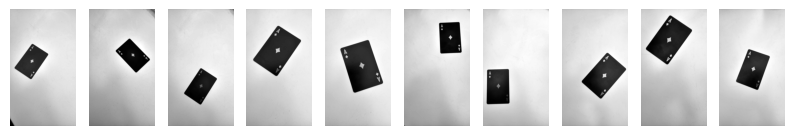

In [3]:
# 1. Load & display images
image_files = sorted(os.listdir("clean_pics"))
images = [cv2.imread(os.path.join("clean_pics", img)) for img in image_files]

images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
images = [cv2.resize(img, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA) for img in images]
images = [cv2.medianBlur(img, ksize=5) for img in images]

fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
for ax, img in zip(axes, images):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()

In [4]:
# 2. Extract keypoints/descriptors
img_keyp_pairs = []
descriptors_dict = {}
keypoints_dict = {}

orb = cv2.ORB_create()
for i in range(len(images)):
    keypoints, descriptors = orb.detectAndCompute(images[i], None)

    for keyp in keypoints:
        keyp.size *= 5

    keypoints_dict[image_files[i]] = keypoints
    
    descriptors_dict[image_files[i]] = {}
    for k in range(len(keypoints)):
        descriptors_dict[image_files[i]][keypoints[k]] = descriptors[k]

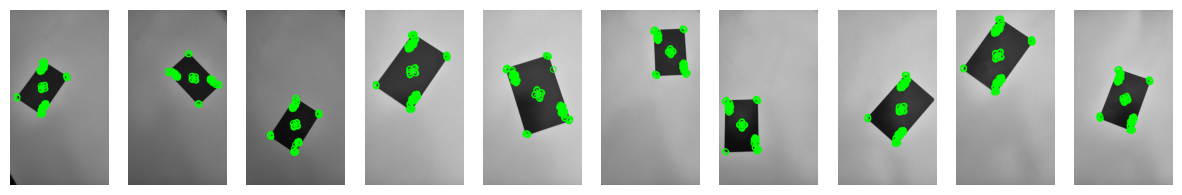

In [5]:
# 3. Visualise all raw keypoints
images_with_keypoints = []
for i in range(len(images)):
    images_with_keypoints.append(cv2.drawKeypoints(images[i], keypoints_dict[image_files[i]], None, color=(0, 255, 0), flags=0))
    
    for keyp in keypoints_dict[image_files[i]]:
        cv2.circle(images_with_keypoints[-1], tuple(int(c) for c in keyp.pt), radius=15, color=(0, 255, 0), thickness=3)
    
fig, axes = plt.subplots(1, len(images_with_keypoints), figsize=(15, 5))
for ax, img in zip(axes, images_with_keypoints):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()

In [6]:
# 4. Apply NMS
neighborhood_size = 1/16 #the used pictures have too fine details for nms with keypoint size/2 to be effective

keypoints_nms = {}
for i in range(len(images)):
    keypoints = sorted(keypoints_dict[image_files[i]], key=lambda x: x.response, reverse=True)
    
    keep_points = []

    for keyp in keypoints:
        keep = True

        keep = all(np.linalg.norm(np.array(keepp.pt) - np.array(keyp.pt)) > keepp.size*neighborhood_size for keepp in keep_points)

        if keep:
            keep_points.append(keyp)
        
    keypoints_nms[image_files[i]] = keep_points

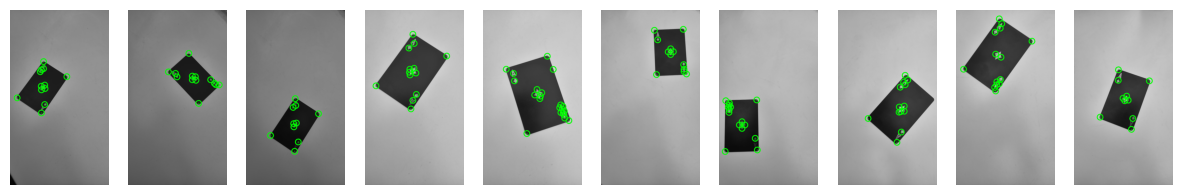

In [7]:
# 5. Visualise retained keypoints
images_with_keypoints = []
for i in range(len(images)):
    images_with_keypoints.append(cv2.drawKeypoints(images[i], keypoints_nms[image_files[i]], None, color=(0, 255, 0), flags=0))
    
    for keyp in keypoints_nms[image_files[i]]:
        cv2.circle(images_with_keypoints[-1], tuple(int(c) for c in keyp.pt), radius=15, color=(0, 255, 0), thickness=3)
    
fig, axes = plt.subplots(1, len(images_with_keypoints), figsize=(15, 5))
for ax, img in zip(axes, images_with_keypoints):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()

In [8]:
# 6. Save the NMS‑pruned descriptors and keypoint metadata

# images            = list of images
# image_files       = list of image names (same order as images)
# keypoints_nms     = dict{image_file : [keypoints_nms]}
# descriptors_nms   = dict{image_file : {keypoint : descriptor}}

descriptors_nms = {}
for i in range(len(images)):
    descriptors_nms[image_files[i]] = {}

    for keyp in keypoints_nms[image_files[i]]:
        descriptors_nms[image_files[i]][keyp] = descriptors_dict[image_files[i]][keyp]
        

# Feature‑Space Clustering and Spatial Analysis
**Assumes the variables created in the previous code cells are present**:
* `images` – list of RGB images
* `image_files` – corresponding filenames
* `keypoints_nms` – list of non‑maximum‑suppressed keypoint lists per image
* `descriptors_nms` – matching list of NumPy descriptor matrices (`uint8`, 32 × N)

Run this notebook in the *same* kernel session **after** executing the extraction notebook, or paste these cells below the earlier ones.

### Pipeline
 7. Cluster keypoint descriptors (enhanced descriptors)
 8. Compute center of gravity of keypoints and displacement vector 
    to center of gravity in every "object" (here: cow) training image
 9. Save per‑cluster & displacement data ("visual words"/"codebook entries" of the objects
10. Generate a check plot for each training image

In [9]:
# 7. Cluster keypoint descriptors (enhanced descriptors)
descriptor_centers = {}
keypoints_per_cluster = {}
labels = []

min_kp = 1000
for img in image_files:
    if min_kp > len(keypoints_nms[img]):
        min_kp = len(keypoints_nms[img])

for img in image_files:
    keypoints_per_cluster[img]={}

    keyp_nms = []
    descr_nms = []
    for keyp in keypoints_nms[img]:
        keyp_nms.append(keyp)
        descr_nms.append(descriptors_nms[img][keyp])
    np_descr_nms = np.float32(descr_nms)

    s = 5
    k = s if len(np_descr_nms) >= s else len(np_descr_nms)
    _, labels_list, centers = cv2.kmeans(np_descr_nms, k, None, (cv2.TermCriteria_EPS + cv2.TermCriteria_MAX_ITER, 20, 0.5), 1, cv2.KMEANS_PP_CENTERS)

    descriptor_centers[img] = centers

    for l in range(len(labels_list)):
        if tuple(centers[labels_list[l]][0]) in keypoints_per_cluster[img]:
            keypoints_per_cluster[img][tuple(centers[labels_list[l]][0])].append(keyp_nms[l])
        else:
            keypoints_per_cluster[img][tuple(centers[labels_list[l]][0])] = [keyp_nms[l]]

    labels = np.unique(labels_list)

# labels = []   = [0-k] with 0-k being the order of the indices of the descriptors centers list
# descriptor_centers = {image : [centers]} (center of the feature), same order as keypoints per cluster
# keypoints_per_cluster = {image : {tuple(center) : [keypoints]}}  index of centers can be used as label

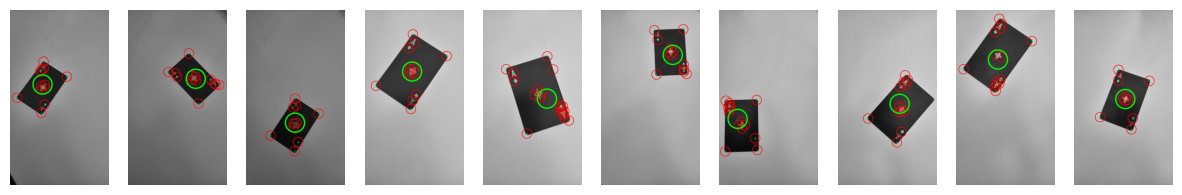

In [34]:
# 8. Compute center of gravity of keypoints and displacement vector 
#    to center of gravity in every "object" (here: cow) training image
displacements = {}
for img in image_files:

    needed_points = []
    for center in keypoints_per_cluster[img].keys():
        needed_points.extend([k.pt for k in keypoints_per_cluster[img][center]])
    card_center = np.mean(np.array(needed_points), axis=0)

    displacements[img] = {}
    for center in keypoints_per_cluster[img].keys():
        displacements[img][center] = []
        for keyp in keypoints_per_cluster[img][center]:

            displacement = np.array(np.array(keyp.pt) - card_center)  
            """
            displacement /= keyp.size
            theta = np.radians(keyp.angle)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                        [np.sin(theta), np.cos(theta)]])
            normalized_displacement = rotation_matrix @ displacement 
            """

            displacements[img][center].extend([displacement])

# displacements = {image : {label : [displacements]}}   with labels: 0 - len(centers)


# testing:
disp_imgs = []
for i in range(len(images)):
    img_t = cv2.drawKeypoints(images[i], keypoints_nms[image_files[i]], None, color=(0, 255, 0), flags=0)

    #keypoints
    for keyp in keypoints_nms[image_files[i]]:
        cv2.circle(img_t, tuple(int(c) for c in keyp.pt), radius=25, color=(255, 0, 0), thickness=2)

    #center
    needed_points = []
    for center in keypoints_per_cluster[image_files[i]].keys():
        needed_points.extend([k.pt for k in keypoints_per_cluster[image_files[i]][center]])
    card_center = np.mean(np.array(needed_points), axis=0)
    disp_imgs.append(cv2.circle(img_t, tuple(card_center.astype(int)), 50, (0, 255, 0), 5))
    

fig, axes = plt.subplots(1, len(disp_imgs), figsize=(15, 5))
for ax, img in zip(axes, disp_imgs):
    ax.imshow(img)
    ax.axis("off")
plt.show()

#green: center
#blue: cluster
#red: nms keypoint

In [11]:
# 9. Save per‑cluster & displacement data ("visual words"/"codebook entries" of the objects

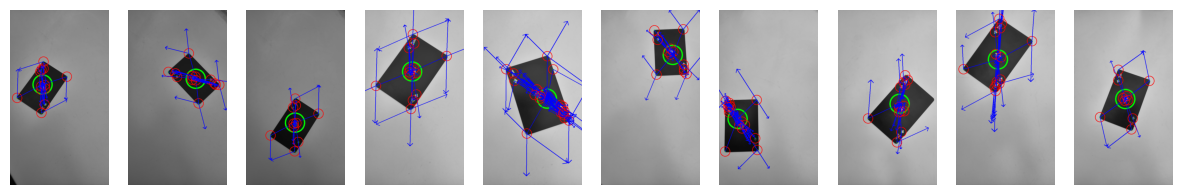

In [35]:
# 10. Check plot features and displacement vectors for each training image
img_w_centers_and_disps = []
for i in range(len(image_files)):
    img_t = cv2.drawKeypoints(images[i], keypoints_nms[image_files[i]], None, color=(0, 255, 0), flags=0)

    #center
    needed_points = []
    for center in keypoints_per_cluster[image_files[i]].keys():
        needed_points.extend([k.pt for k in keypoints_per_cluster[image_files[i]][center]])
    card_center = np.mean(np.array(needed_points), axis=0)
    img_t = cv2.circle(img_t, tuple(card_center.astype(int)), 50, (0, 255, 0), 5)

    #vectors
    for center in keypoints_per_cluster[image_files[i]].keys():
        for keyp in keypoints_per_cluster[image_files[i]][center]:
        #keypoints
            cv2.circle(img_t, tuple(int(c) for c in keyp.pt), radius=25, color=(255, 0, 0), thickness=2)
            
            #offset vectors
            for displacement in displacements[image_files[i]][center]:
                point = np.array(keyp.pt)

                """
                displacement_scaled = np.array(displacement) / keyp.size 
                theta = np.radians(keyp.angle)
                rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                            [np.sin(theta), np.cos(theta)]])
                displacement = rotation_matrix @ displacement_scaled 
                """
                
                endpoint = tuple((point - displacement).astype(int))
                point = tuple(point.astype(int))


                img_t = cv2.arrowedLine(img_t, point, endpoint, color=(0,0,255), thickness=2)
                
    img_w_centers_and_disps.append(img_t)
    
fig, axes = plt.subplots(1, len(img_w_centers_and_disps), figsize=(15, 5))
for ax, img in zip(axes, img_w_centers_and_disps):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()

# here for each keypoint all displacement vectors from the cluster it is part of are drawn. 
# I honestly dont understand why there are no vectors not pointing in the center in the cows example

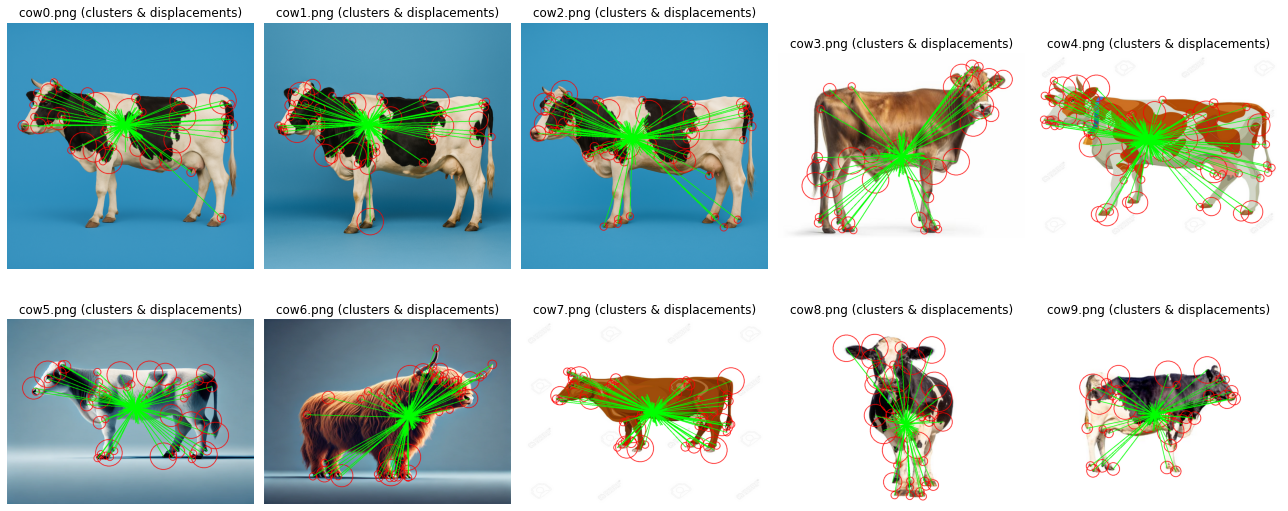

# Let the Features Vote with all their Displacement Vectors:
# Cluster‑wise Displacement Field Visualisation

Essentially, here we apply the detection pipeline to the training images. In general it has to be **applied to the test images**, i.e. in the detection step. We nevertheless do it in order to conduct a plausibility test.

**Prerequisite**:
`images`, `image_files`, `keypoints_nms`, `displacements_per_image`, `cluster_labels_per_image`.

### Pipeline:
11. Build a lookup table that is mapping **all** displacement vectors of a k‑means cluster to a keypoint whose feature vector let's it belong to that cluster.
12. Draw, for every keypoint in every image, **the entire displacement set of its cluster** — giving a dense field that reveals spatial patterns the visual word is linked to.


In [36]:
# 11. Build a lookup table that is mapping **all** displacement vectors of a k‑means cluster to a keypoint whose feature vector let's it belong to that cluster.

# We do that by building a list of cluster feature vectors whos indices indicate all keypoints belonging in them and their displacements

################################################# descriptor_centers = {image : [centers]} (center of the feature as feature vector)
#   -> labels = index of center
for img in image_files:
    i = None
    #print(len(descriptor_centers[img]))
    #print(descriptor_centers[img])

################################################# keypoints_per_cluster = {image : {labels : [keypoints]}}
for img in image_files:
    for center in keypoints_per_cluster[img].keys():
        i = None
        #print(len(keypoints_per_cluster[img][center]))
        #print(keypoints_per_cluster[img][center])

################################################# displacements = {image : {label : [displacements]}}
for img in image_files:
    for center in keypoints_per_cluster[img].keys():
        i = None
        #print(len(displacements[img][center]))
        #print(displacements[img][center])


all_cluster_displacements = {}
for img in image_files:
    for center in keypoints_per_cluster[img].keys():
        all_cluster_displacements[center] = displacements[img][center]

# all_cluster_displacements = {tuple(feature_vector) : [displacement_vectors]}


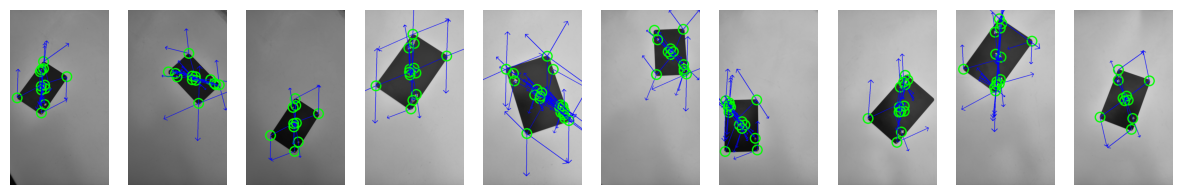

In [37]:
# 12. Draw, for every keypoint in every image, **the entire displacement set of its cluster** — giving a dense field that reveals spatial patterns the visual word is linked to.

img_w_kp_and_disps = []

cluster_vectors = [np.array(centoid) for centoid in list(all_cluster_displacements.keys())]

for i in range(len(image_files)):
    im = image_files[i]
    img_t = cv2.drawKeypoints(images[i], keypoints_nms[im], None, color=(255, 255, 0), flags=0)
    
    for keyp in keypoints_nms[im]:
            descriptor = descriptors_nms[im][keyp]

            distance_vector = [np.linalg.norm(descriptor - des_arr) for des_arr in cluster_vectors]
            idx_of_most_similar = np.argmin(distance_vector)
                                               
            for displacement in all_cluster_displacements[tuple(cluster_vectors[idx_of_most_similar])]:

                """
                displacement_scaled = np.array(displacement)*keyp.size
                theta = np.radians(keyp.angle)
                rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                            [np.sin(theta), np.cos(theta)]])
                displacement = rotation_matrix @ displacement_scaled 
                """

                point = np.array(keyp.pt)
                offset = np.array(displacement)
                
                endpoint = tuple((point - offset).astype(int))
                startpoint = tuple(point.astype(int))

                img_t = cv2.circle(img_t, startpoint, 25, (0, 255, 0), 5)
                img_t = cv2.arrowedLine(img_t, startpoint, endpoint, color=(0,0,255), thickness=2)

    img_w_kp_and_disps.append(img_t)

fig, axes = plt.subplots(1, len(img_w_kp_and_disps), figsize=(15, 5))
for ax, img in zip(axes, img_w_kp_and_disps):
    ax.imshow(img, cmap="grey")
    ax.axis("off")
plt.show()

# above:
# get displacement vector for cluster closest to every keypoint and print them

# Save *all* enriched feature data to file
Pack every datum you now have — i.e. keypoint metadata, descriptors, cluster labels, displacement vectors, **and** the global displacement lists per cluster — into self‑contained, human‑readable files.

For instance:

* For each image write a compressed **`.npz`**:
  * `x`, `y`, `size`, `angle`, `response`, `cluster`, `dx`, `dy`, `descriptors` (Your features may have different data.)
* A single **`cluster_displacements.json`** maps each k‑means label to the list of `[dx, dy]` vectors observed in that cluster.

In [38]:
# 13. Save all enriched feature data to file

imgnr = 1
for im in image_files:
    positions = []
    sizes = []
    angles = []
    responses = []
    octaves = []
    descriptors = []

    for kp in keypoints_nms[im]:
        positions.append(kp.pt)
        sizes.append(kp.size)
        angles.append(kp.angle)
        responses.append(kp.response)
        octaves.append(kp.octave)
        descriptors.append(descriptors_nms[im][kp])

    np.savez(str(imgnr)+".npz", positions=np.array(positions), sizes=np.array(sizes), angles=np.array(angles), responses=np.array(responses), octaves=np.array(octaves), descriptors=np.array(descriptors))
    imgnr += 1

import json

# all_cluster_displacements = {tuple(feature_vector) : [displacement_vectors]}
save_data = {str(k) : [array.tolist() for array in v] for k,v in all_cluster_displacements.items()}
with open("cluster_displacements.json", "w") as f:
    json.dump(save_data, f, indent=4)

In [39]:
# 14. Make sure you are also able to read the data of the files back into memory

for i in range(5):
    t = i+1
    data = np.load(str(t)+".npz")
    positions = data["positions"]
    sizes = data["sizes"]
    angles = data["angles"]
    responses = data["responses"]
    octaves = data["octaves"]
    descriptors = data["descriptors"]

#    print(positions)
#    print(sizes)
#    print(angles)
#    print(responses)
#    print(octaves)
#    print(descriptors)


# Voting Procedure

Implement a voting procedure.

For instance:

15. Put a low resolution grid of voting bins across your image, cast the keypoint's votes to the bins, count the votes and display them. It may be adequate to indicate the grid cell with maximum votes in a special way.

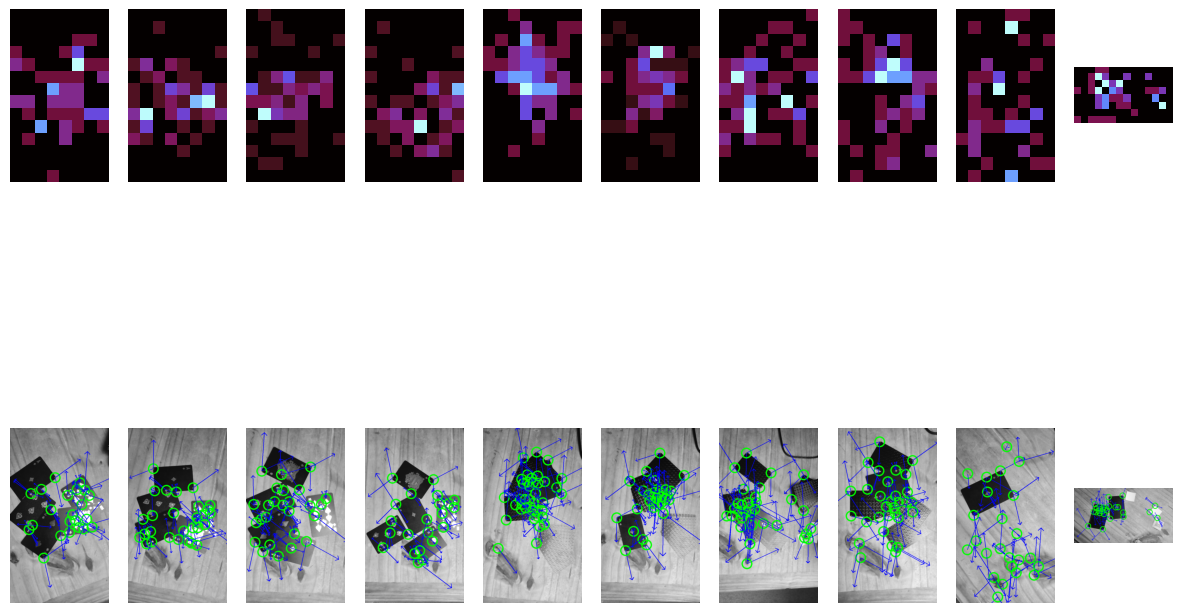

In [40]:
# 15. Put a low resolution grid of voting bins across your image, cast the keypoint's votes to the bins, count the votes and display them.

# 1. Load & display images
image_files = sorted(os.listdir("real_pics"))
images = [cv2.imread(os.path.join("real_pics", img)) for img in image_files]

images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
images = [cv2.resize(img, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA) for img in images]
images = [cv2.medianBlur(img, ksize=5) for img in images]

# 2. Extract keypoints/descriptors
img_keyp_pairs = []
descriptors_dict = {}
keypoints_dict = {}

orb = cv2.ORB_create()
for i in range(len(images)):
    keypoints, descriptors = orb.detectAndCompute(images[i], None)

    for keyp in keypoints:
        keyp.size *= 5

    keypoints_dict[image_files[i]] = keypoints
    
    descriptors_dict[image_files[i]] = {}
    for k in range(len(keypoints)):
        descriptors_dict[image_files[i]][keypoints[k]] = descriptors[k]

# 4. Apply NMS
neighborhood_size = 1/8 #the used pictures have too fine details for nms with keypoint size/2 to be effective

keypoints_nms = {}
for i in range(len(images)):
    keypoints = sorted(keypoints_dict[image_files[i]], key=lambda x: x.response, reverse=True)
    
    keep_points = []

    for keyp in keypoints:
        keep = True

        keep = all(np.linalg.norm(np.array(keepp.pt) - np.array(keyp.pt)) > keepp.size*neighborhood_size for keepp in keep_points)

        if keep:
            keep_points.append(keyp)
        
    keypoints_nms[image_files[i]] = keep_points

# 6. Save the NMS‑pruned descriptors and keypoint metadata

# images            = list of images
# image_files       = list of image names (same order as images)
# keypoints_nms     = dict{image_file : [keypoints_nms]}
# descriptors_nms   = dict{image_file : {keypoint : descriptor}}

descriptors_nms = {}
for i in range(len(images)):
    descriptors_nms[image_files[i]] = {}

    for keyp in keypoints_nms[image_files[i]]:
        descriptors_nms[image_files[i]][keyp] = descriptors_dict[image_files[i]][keyp]
        

# vote on clusters
scale = 1/64
maps = []
real_img_vecs = []

cluster_vectors = [np.array(centoid) for centoid in list(all_cluster_displacements.keys())]

for i in range(len(image_files)):
    im = image_files[i]

    height, width = images[i].shape
    height = (int)(height*scale)
    width = (int)(width*scale)

    heatmap = np.zeros((height, width), dtype=np.float32)
    img_t = cv2.drawKeypoints(images[i], keypoints_nms[im], None, color=(255, 255, 0), flags=0)

    for keyp in keypoints_nms[im]:
        descriptor = descriptors_nms[im][keyp]

        distance_vector = [np.linalg.norm(descriptor - des_arr) for des_arr in cluster_vectors]
        idx_of_most_similar = np.argmin(distance_vector)
                                            
        for displacement in all_cluster_displacements[tuple(cluster_vectors[idx_of_most_similar])]:

            # skip scaling and all that
            """
            displacement_scaled = np.array(displacement)*keyp.size
            theta = np.radians(keyp.angle)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                        [np.sin(theta), np.cos(theta)]])
            displacement = rotation_matrix @ displacement_scaled 
            """

            point = np.array(keyp.pt)
            offset = np.array(displacement)
            
            endpoint = tuple((point - offset).astype(int))
            startpoint = tuple(point.astype(int))
            
            img_t = cv2.circle(img_t, startpoint, 25, (0, 255, 0), 5)
            img_t = cv2.arrowedLine(img_t, startpoint, endpoint, color=(0,0,255), thickness=2)

            x, y = endpoint
            
            heatmap[(int)((y*scale)%height), (int)((x*scale)%width)] += 1

    heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
    heatmap = np.uint8(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_MAGMA)

    maps.append(heatmap)

    real_img_vecs.append(img_t)


fig, axes = plt.subplots(2, len(maps), figsize=(15, 10))
for i, (map, img) in enumerate(zip(maps, real_img_vecs)):
    axes[0, i].imshow(map, cmap="grey")
    axes[1, i].imshow(img, cmap="grey")
    axes[0, i].axis("off")
    axes[1, i].axis("off")
plt.show()
# color map: black -> purple -> red -> yellow -> white

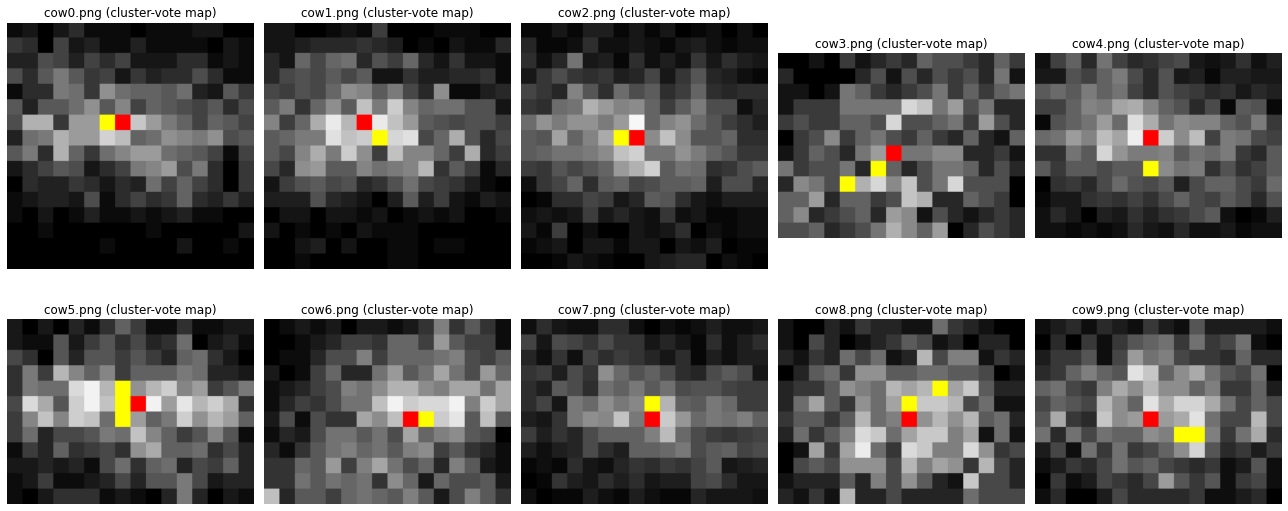

# Background Analysis

Apply this jupyter notebook to the background images also.

For the background images the keypoint clusters and its descriptor vectors are important. The displacement vectors will not be used, as background covers the whole image; it is not limited to a segment covering a part of the image only.

Make sure you do not overwrite the data of the foreground analysis by using adequate file naming conventions.

In [41]:

# 1. Load & display images
image_files = sorted(os.listdir("bg_pics"))
images = [cv2.imread(os.path.join("bg_pics", img)) for img in image_files]

images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
images = [cv2.resize(img, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA) for img in images]
images = [cv2.medianBlur(img, ksize=5) for img in images]

# 2. Extract keypoints/descriptors
img_keyp_pairs = []
descriptors_dict = {}
keypoints_dict = {}

orb = cv2.ORB_create()
for i in range(len(images)):
    keypoints, descriptors = orb.detectAndCompute(images[i], None)

    for keyp in keypoints:
        keyp.size *= 5

    keypoints_dict[image_files[i]] = keypoints
    
    descriptors_dict[image_files[i]] = {}
    for k in range(len(keypoints)):
        descriptors_dict[image_files[i]][keypoints[k]] = descriptors[k]

# 4. Apply NMS
neighborhood_size = 1/8 #the used pictures have too fine details for nms with keypoint size/2 to be effective

keypoints_nms = {}
for i in range(len(images)):
    keypoints = sorted(keypoints_dict[image_files[i]], key=lambda x: x.response, reverse=True)
    
    keep_points = []

    for keyp in keypoints:
        keep = True

        keep = all(np.linalg.norm(np.array(keepp.pt) - np.array(keyp.pt)) > keepp.size*neighborhood_size for keepp in keep_points)

        if keep:
            keep_points.append(keyp)
        
    keypoints_nms[image_files[i]] = keep_points

# 6. Save the NMS‑pruned descriptors and keypoint metadata

# images            = list of images
# image_files       = list of image names (same order as images)
# keypoints_nms     = dict{image_file : [keypoints_nms]}
# descriptors_nms   = dict{image_file : {keypoint : descriptor}}

descriptors_nms = {}
for i in range(len(images)):
    descriptors_nms[image_files[i]] = {}

    for keyp in keypoints_nms[image_files[i]]:
        descriptors_nms[image_files[i]][keyp] = descriptors_dict[image_files[i]][keyp]
        
positions = []
sizes = []
angles = []
responses = []
octaves = []
descriptors = []
for im in image_files:
    for kp in keypoints_nms[im]:
        positions.append(kp.pt)
        sizes.append(kp.size)
        angles.append(kp.angle)
        responses.append(kp.response)
        octaves.append(kp.octave)
        descriptors.append(descriptors_nms[im][kp])

np.savez("bg.npz", positions=np.array(positions), sizes=np.array(sizes), angles=np.array(angles), responses=np.array(responses), octaves=np.array(octaves), descriptors=np.array(descriptors))

